In [7]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import Pipeline
import dill as pickle
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

# Allow import from parent directory (for utils for example)
#sys.path.append(os.path.abspath(os.path.join('..')))
import fbo_scraper.train as train
from fbo_scraper.binaries import binary_path


# Import the Estimator and Take a Look

In [5]:
estimator = pickle.load(open(Path(binary_path, 'estimator.pkl'),'rb'))

ModuleNotFoundError: No module named 'sklearn.feature_selection.univariate_selection'

By listing the estimator steps, we get the the details of the classifier pipeline with the best chosen hyperparameters. The estimator is a pipeline of:

 1. a TF-IDF vectorizor (with L2 norm), 
 2. a KBest selector (top 2000), and 
 3. a stochastic gradient descent (SGD) classifier

Because the SGD classifier uses a "modified_huber" loss function, it not only gives us predictions, but probabilities of fit. This could be useful to determine the confidence of the predictions (identifying a "yellow" zone) that could be communicated to users for details and reclassification.

In [3]:
estimator.steps

[('vectorizer',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.012474489021681, max_features=None,
                  min_df=2, ngram_range=(1, 2), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words='english', strip_accents=None,
                  sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True, vocabulary=None)),
 ('select', SelectKBest(k=2000, score_func=<function chi2 at 0x7f42f6fb4730>)),
 ('clf',
  SGDClassifier(alpha=array([0.00156602]), average=False, class_weight='balanced',
                early_stopping=None, epsilon=0.1, eta0=0.0, fit_intercept=True,
                l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
                max_iter=None, n_iter_no_change=None, n_jobs=1,
                penalty='elasticnet', power_t=0.5, random_stat

As a quick sanity check, let's run the estimator on a couple of examples:

In [4]:
estimator.predict(['This is a bunch of words that do not mention what we want to capture',
                   'This is another bunch of words but we care about Section 508 accessibility.'])

array([0, 1])

OK, that makes sense, but what about the cofidence of it being "Green" (1)?

In [5]:
estimator.predict_proba(['This is a bunch of words that do not mention what we want to capture',
                         'This is another bunch of words but we care about Section 508 accessibility.'])[:,1]

array([0.27327843, 0.62025061])

So we're pretty sure that the first line is not GREEN, while the second one is "kind of" GREEN.

Out of curiosity, what are the words (features) that have the most significance choosing between GREEN and RED? We can figure this out by pulling out the features and scores from the estimator steps:

In [6]:
features = estimator.named_steps['vectorizer'].get_feature_names()
mask = estimator.named_steps['select'].get_support()
new_features = [ feature for bool, feature in zip (mask, features) if bool ]
nf = pd.DataFrame({'features': new_features, 'coef': estimator.named_steps['clf'].coef_[0] })
nf.sort_values(['coef'], ascending=0)

,features,coef
1577,section 508,2.143648
1,508,2.119495
830,function perform,1.883782
1304,perform criteria,1.749019
1760,task order,1.524084
...,...,...
1974,wall,-0.411968
90,afb,-0.519698
274,cabl,-0.817065
99,air,-0.976992


# Pull in the Labeled Data

Let's pull in the labeled data from the pkl file. It looks like the estimator was trained off of the result of 80% of the labeled data (which is a great best practice because you can then double check your work on a 20% test set that was set aside).

In [2]:
attachments = pickle.load(open(Path(binary_path, 'train.pkl'),'rb'))
len(attachments)

993

In [3]:
# The following removes numbers (except 508) small and large words, stop words
# and then uses the nltk porter stemmer on the text
x,y = train.prepare_samples(attachments)
len(x), len(y)

(993, 993)

In [4]:
# Now let's pull out the training and test sets the same way that
# the training code appears to pull it out.
x_train, x_test, y_train, y_test = train.train_test_split(x, y, stratify=y,
                                                          test_size=0.2, random_state=123)
len(x_train), len(y_train), len(x_test), len(y_test)

(794, 794, 199, 199)

# Retrain the Model So We Have a Clean Test Set
I ran the experiments below and discovered that the probability distributions and classification reports for the test and training sets were almost identical. So I have to conclude that I don't have a "clean" test set (that I have some overlap between the test set and the training set used to create the estimator). So to make the test set clean, let me re-train the estimator on the training set.

In [12]:
estimator = Pipeline([('vectorizer', 
                       TfidfVectorizer(stop_words='english', ngram_range=(1, 2),
                                       min_df=2, max_df=0.95,
                                       norm='l2', sublinear_tf=True)),
                     ('select', SelectKBest(chi2, k=2000)),
                     ('clf', SGDClassifier(class_weight = 'balanced', 
                                           alpha=0.00156602,
                                           loss='modified_huber'))])
estimator.steps


[('vectorizer',
  TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2), stop_words='english',
                  sublinear_tf=True)),
 ('select', SelectKBest(k=2000, score_func=<function chi2 at 0x7f2d79a71c60>)),
 ('clf',
  SGDClassifier(alpha=0.00156602, class_weight='balanced', loss='modified_huber'))]

In [13]:
estimator.fit(x_train, y_train);

Re-run our earlier examples:

In [14]:
estimator.predict(['This is a bunch of words that do not mention what we want to capture',
                   'This is another bunch of words but we care about Section 508 accessibility.'])

array([0, 1])

In [15]:
estimator.predict_proba(['This is a bunch of words that do not mention what we want to capture',
                         'This is another bunch of words but we care about Section 508 accessibility.'])[:,1]

array([0.2660059 , 0.57182647])

Because I re-trained, did my selected K features change?

In [19]:
features = estimator.named_steps['vectorizer'].get_feature_names_out()
mask = estimator.named_steps['select'].get_support()
new_features = [ feature for bool, feature in zip (mask, features) if bool ]
nf = pd.DataFrame({'features': new_features, 'coef': estimator.named_steps['clf'].coef_[0] })
nf.sort_values(['coef'], ascending=0)

,features,coef
1581,section 508,1.898106
1,508,1.859217
824,function perform,1.570113
1303,perform criteria,1.473813
1768,task order,1.466694
...,...,...
1983,wall,-0.392597
90,afb,-0.544311
276,cabl,-0.701556
99,air,-0.917128


Slightly different coefficients, so it looks like I have slightly different training data or paramters. But overall they didn't change too much. So I should be able to use this to look at the confidence of the predictions.

# So, How Confident are the Predictions?
Let's create a histogram of the probability of predicting GREEN (1)

In [20]:
test_prob = estimator.predict_proba(x_test)[:,1]

array([10.,  1.,  0.,  0.,  6., 33., 39., 26., 23., 11., 14.,  2.,  6.,
        2.,  3.,  0.,  5.,  3.,  2., 13.])

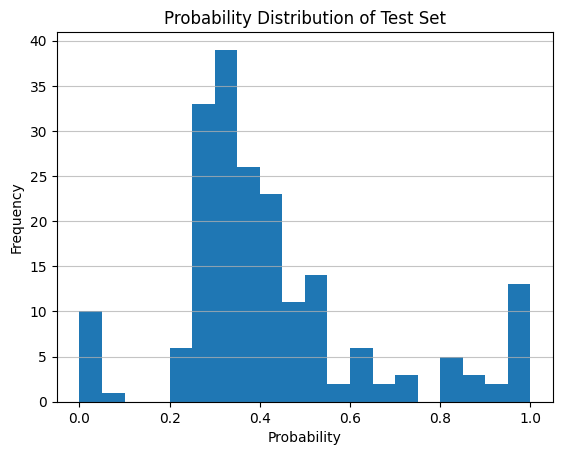

In [21]:
bins = 20
n, b, patches = plt.hist(x=test_prob, bins=bins)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution of Test Set')
n

That is an interesting clump around 0.3-0.35, but there is a significant amount in the 0.4-0.6 range...

What about the training set?

In [22]:
train_prob = estimator.predict_proba(x_train)[:,1]

array([ 41.,   0.,   2.,   3.,  20., 172., 135.,  96.,  80.,  48.,  47.,
        25.,  18.,  15.,  12.,  13.,   5.,   8.,  11.,  43.])

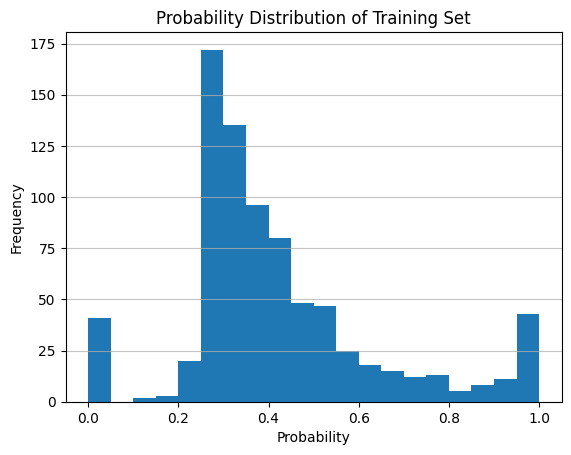

In [23]:
bins = 20
n, b, patches = plt.hist(x=train_prob, bins=bins)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution of Training Set')
n

So comparing the distributions of the training and test sets, they are similar, but the test set has more of a "clump" in the 0.4-0.6 range, which means there is more to "learn" as expected.  But this also means that we can use predict_proba to identify this "yellow" or inconclusive set of predictions.

# Quick Sanity Check
Let's do a sanity check by doing the predictions and calculating the classification report

In [24]:
y_pred = estimator.predict(x_test)

In [25]:
print(metrics.classification_report(y_test, y_pred, target_names=['red', 'green']))

              precision    recall  f1-score   support

         red       0.89      0.92      0.90       145
       green       0.76      0.70      0.73        54

    accuracy                           0.86       199
   macro avg       0.83      0.81      0.82       199
weighted avg       0.86      0.86      0.86       199



In [26]:
y_train_pred = estimator.predict(x_train)

In [27]:
print(metrics.classification_report(y_train, y_train_pred, target_names=['red', 'green']))

              precision    recall  f1-score   support

         red       0.92      0.95      0.93       577
       green       0.85      0.77      0.81       217

    accuracy                           0.90       794
   macro avg       0.88      0.86      0.87       794
weighted avg       0.90      0.90      0.90       794



Good, my training set performed better than my test set (so I can be more confident that it is a "clean" test set and that my analysis above is valid)

In [28]:
# Dump New Estimator Model 

train.pickle_model(estimator)

# Utilizing the train.train functionality

Getting the "Best Estimator"

In [8]:
# Running train.train to see results with default parameters

random_state = 123
score='roc_auc'
n_iter_search = 500

clf = SGDClassifier(class_weight = 'balanced')

scoring = {'accuracy': metrics.make_scorer(metrics.accuracy_score),
               'roc_auc': metrics.make_scorer(metrics.roc_auc_score),
               'precision': metrics.make_scorer(metrics.average_precision_score),
               'fbeta':metrics.make_scorer(metrics.fbeta_score,beta=.5),
               'recall':metrics.make_scorer(metrics.recall_score)}

pipe = Pipeline([('vectorizer', TfidfVectorizer(stop_words='english')),
                        ('select', SelectKBest(chi2)),
                        ('clf', clf)])

param_dist = train.get_param_distribution()

random_search = RandomizedSearchCV(pipe,
                                       param_distributions = param_dist,
                                       scoring = scoring,
                                       refit = score,
                                       n_iter = n_iter_search,
                                       cv = 5,
                                       n_jobs = -1,
                                       verbose = 1,
                                       random_state = random_state)


# Random Search Fit

In [10]:
random_search.fit(x_train, y_train)

y_pred = random_search.predict(x_test)
#get the col number of the positive class (i.e. green)
positive_class_col = list(random_search.classes_).index(1)
try:
    y_score = random_search.predict_proba(x_test)[:,positive_class_col]
except AttributeError:
    y_score = random_search.decision_function(x_test)
average_precision = metrics.average_precision_score(y_test, y_score)
acc = metrics.accuracy_score(y_test,y_pred)
try:
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
except ValueError:
    roc_auc = None
precisions, recalls, _ = metrics.precision_recall_curve(y_test, y_score)
try:
    auc = metrics.auc(recalls, precisions)
except ValueError:
    auc = None
fbeta = metrics.fbeta_score(y_test,y_pred,beta=1.5)
recall = metrics.recall_score(y_test,y_pred)
best_estimator = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_
result_values = [y_pred, y_score, precisions, recall, average_precision,
                    acc, roc_auc, auc, fbeta, recalls, best_score, best_estimator, y_test]
result_keys = ['y_pred', 'y_score', 'precisions', 'recall', 'average_precision',
                'acc', 'roc_auc', 'auc', 'fbeta', 'recalls','best_score','best_estimator','y_test']
results = {k:v for k,v in zip(result_keys,result_values)}

KeyboardInterrupt: 

# So, How Confident are the Predictions?
Let's create a histogram of the probability of predicting GREEN (1)

In [ ]:
test_prob = best_estimator.predict_proba(x_test)[:,1]

In [ ]:
bins = 20
n, b, patches = plt.hist(x=test_prob, bins=bins)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution of Test Set')
n